In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
import torch
import numpy as np
import random
import json
import gc
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from huggingface_hub import notebook_login
from PIL import Image
import requests
from matplotlib import pyplot as plt
import pandas as pd

IMAGE_PATH=Path('inshop/')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/fashion_qva/inshopping/inshop.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
   creating: inshop/img/WOMEN/Tees_Tanks/id_00005020/
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005020/06_1_front.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005020/06_2_side.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005020/06_3_back.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005020/06_7_additional.jpg  
   creating: inshop/img/WOMEN/Tees_Tanks/id_00005033/
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/03_1_front.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/03_2_side.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/03_3_back.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/03_4_full.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/03_6_flat.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/06_1_front.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/06_2_side.jpg  
  inflating: inshop/img/WOMEN/Tees_Tanks/id_00005033/06_3_back.jp

# Generate VQA dataset

## Dataset loading and reduction (to lower training time)

In [ ]:
df_main=pd.read_excel('/content/drive/MyDrive/fashion_qva/inshopping/list_color_cloth.xlsx')
df_attributes=pd.read_excel('/content/drive/MyDrive/fashion_qva/inshopping/list_attr_items.xlsx')
df_att_names=pd.read_excel('/content/drive/MyDrive/fashion_qva/inshopping/list_attr_cloth.xlsx')
print('original dataset size: ',len(df_main))

#filter only frontal images to reduce the dataset and training time
df_main = df_main[df_main['image_name'].str.contains('front')]
print('frontal image dataset size: ',len(df_main))

#sample 6030 random images to reduce dataset, use 30 of those images for testing
df_main = df_main.sample(n=6030).reset_index(drop=True)
df_test=df_main[-30:]
df_main=df_main[:-30]
print('random sampled frontal dataset size: ',len(df_main))



original dataset size:  52712
frontal image dataset size:  12861
random sampled frontal dataset size:  6000


## Remove attribute that is too common in the dataset
(to avoid overfitting this attribute)

In [ ]:
df_attributes2=df_attributes.copy()
df_attributes2.drop('item_id',axis=1,inplace=True)
df_attributes2.replace(-1,0)
index=df_attributes2.sum()[df_attributes2.sum()>2000].index.to_list()
print(df_attributes2.sum()[index])
#Column1.<index> is offset by 2 of the att_name
#(attribute columns starts at position 2 with name Column1.2 )
att_index_ignore=[]
for column_index in [0,198,317]:
  print('att:',df_att_names.iloc[column_index][0],"| index:",column_index)
  att_index_ignore.append(column_index)
print('att index to ignore:', att_index_ignore)

Column1.2      2026
Column1.200    2556
Column1.319    3320
dtype: int64
att: lightweight | index: 0
att: light | index: 198
att: line | index: 317
att index to ignore: [0, 198, 317]


## Generate new features

In [ ]:
def generate_df_columns(row,att_index_to_ignore):
  splitted_path=row['image_name'].split("/")
  id = splitted_path[-2]
  id_index = int(id.split("_")[1].lstrip("0"))
  temp_name = splitted_path[-3].replace("_"," ").lower()
  temp_name = temp_name.split()
  processed_words = [word[:-1] if word.endswith('s') else word for word in temp_name]
  cloth_name = ' '.join(processed_words)
  #fix transformation of dresses to dresse (should be dress)
  if cloth_name =='dresse':
    cloth_name='dress'
  # fix "shirt polo" to "polo shirt"
  if cloth_name == 'shirt polo':
    cloth_name = 'polo shirt'
  row['cloth_name'] = cloth_name
  cloth_att=''
  if id == df_attributes.iloc[id_index-1]['item_id']:
    attribute_info = df_attributes.iloc[id_index-1][1:]
    column_index=0
    for column in attribute_info:
      if column_index in att_index_to_ignore:
        column_index=+1
        continue
      if column == 1:
        cloth_att+=' '+df_att_names.iloc[column_index][0]
      column_index+=1
  else:
    print("attribute index error")
  row['cloth_att'] = cloth_att.lstrip(' ')
  return row

df_main = df_main.apply(generate_df_columns,att_index_to_ignore=att_index_ignore, axis=1)
df_test = df_test.apply(generate_df_columns,att_index_to_ignore=att_index_ignore, axis=1)

In [ ]:
df_main

,image_name,clothes_color,cloth_name,cloth_att
0,img/WOMEN/Skirts/id_00001558/14_1_front.jpg,Navy,skirt,knit cotton unlined spandex top dress lined el...
1,img/WOMEN/Tees_Tanks/id_00002201/15_1_front.jpg,Teal,tee tank,knit cotton spandex classic round cami bust ne...
2,img/WOMEN/Tees_Tanks/id_00004682/03_1_front.jpg,Taupe,tee tank,polyester knit rayon spandex top tee sleek lon...
3,img/WOMEN/Cardigans/id_00001542/01_1_front.jpg,Olive,cardigan,knit pockets tee pocket jeans patch acrylic ca...
4,img/WOMEN/Tees_Tanks/id_00006411/01_1_front.jpg,Black,tee tank,knit cotton dress round tee neck comfy soft si...
...,...,...,...,...
5995,img/WOMEN/Tees_Tanks/id_00003755/09_1_front.jpg,Rust,tee tank,knit cotton spandex top round ribbed little ne...
5996,img/WOMEN/Pants/id_00002650/02_1_front.jpg,Denim,pant,knit cotton pockets elasticized denim pocket d...
5997,img/WOMEN/Tees_Tanks/id_00004498/05_1_front.jpg,White-charcoal,tee tank,polyester knit cotton rayon classic fit tee bo...
5998,img/WOMEN/Blouses_Shirts/id_00004470/02_1_fron...,Cream,blouse shirt,polyester woven unlined top lined round love b...


In [ ]:
df_main['cloth_att']

0       knit cotton unlined spandex top dress lined el...
1       knit cotton spandex classic round cami bust ne...
2       polyester knit rayon spandex top tee sleek lon...
3       knit pockets tee pocket jeans patch acrylic ca...
4       knit cotton dress round tee neck comfy soft si...
                              ...                        
5995    knit cotton spandex top round ribbed little ne...
5996    knit cotton pockets elasticized denim pocket d...
5997    polyester knit cotton rayon classic fit tee bo...
5998    polyester woven unlined top lined round love b...
5999    polyester woven top dress lined elasticized sl...
Name: cloth_att, Length: 6000, dtype: object

In [ ]:
df_main['cloth_name'].value_counts()

tee tank             1680
blouse shirt          956
dress                 839
short                 448
sweater               422
pant                  284
romper jumpsuit       218
jacket coat           210
skirt                 196
sweatshirt hoodie     187
cardigan              184
graphic tee           118
denim                  93
polo shirt             80
jacket vest            42
legging                38
suiting                 5
Name: cloth_name, dtype: int64

In [ ]:
#remove suiting cloths (few examples)
df_main = df_main[df_main['cloth_name'] != 'suiting']
df_test = df_test[df_test['cloth_name'] != 'suiting']

In [ ]:
#generate a negative cloth sample
cloth_names_list = df_main['cloth_name'].unique().tolist()
def generate_negative_cloth_sample(row,cloth_names_list):
  temp_list = cloth_names_list.copy()
  temp_list.remove(row['cloth_name'])
  negative_cloth = random.choice(temp_list)
  return negative_cloth

# Apply the function to all rows
df_main['cloth_negative_sample'] = df_main.apply(generate_negative_cloth_sample, cloth_names_list=cloth_names_list, axis=1)
df_test['cloth_negative_sample'] = df_test.apply(generate_negative_cloth_sample, cloth_names_list=cloth_names_list, axis=1)

<ipython-input-13-df0ee563dff7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['cloth_negative_sample'] = df_main.apply(generate_negative_cloth_sample, cloth_names_list=cloth_names_list, axis=1)


In [ ]:
df_main

,image_name,clothes_color,cloth_name,cloth_att,cloth_negative_sample
0,img/WOMEN/Skirts/id_00001558/14_1_front.jpg,Navy,skirt,knit cotton unlined spandex top dress lined el...,graphic tee
1,img/WOMEN/Tees_Tanks/id_00002201/15_1_front.jpg,Teal,tee tank,knit cotton spandex classic round cami bust ne...,cardigan
2,img/WOMEN/Tees_Tanks/id_00004682/03_1_front.jpg,Taupe,tee tank,polyester knit rayon spandex top tee sleek lon...,skirt
3,img/WOMEN/Cardigans/id_00001542/01_1_front.jpg,Olive,cardigan,knit pockets tee pocket jeans patch acrylic ca...,sweatshirt hoodie
4,img/WOMEN/Tees_Tanks/id_00006411/01_1_front.jpg,Black,tee tank,knit cotton dress round tee neck comfy soft si...,sweater
...,...,...,...,...,...
5995,img/WOMEN/Tees_Tanks/id_00003755/09_1_front.jpg,Rust,tee tank,knit cotton spandex top round ribbed little ne...,graphic tee
5996,img/WOMEN/Pants/id_00002650/02_1_front.jpg,Denim,pant,knit cotton pockets elasticized denim pocket d...,blouse shirt
5997,img/WOMEN/Tees_Tanks/id_00004498/05_1_front.jpg,White-charcoal,tee tank,polyester knit cotton rayon classic fit tee bo...,polo shirt
5998,img/WOMEN/Blouses_Shirts/id_00004470/02_1_fron...,Cream,blouse shirt,polyester woven unlined top lined round love b...,skirt


## Generate questions DF

In [ ]:
def generate_questions(df,step_pos_sample=3,step_neg_sample=3):
  new_df_rows=[]
  skipped_pos_sample=0
  skipped_neg_sample=0
  for index in range(0,len(df)):
    row = df.iloc[index]
    new_df_rows.append({'img':row['image_name'],
                        'question_and_answer':f"Question: What is the color of the {row['cloth_name']}? Answer: {row['clothes_color']}"})

    new_df_rows.append({'img':row['image_name'],
                        'question_and_answer':f"Question: What cloth is the person wearing? Answer: {row['cloth_name']}"})

    #removed in the early testing to reduce complexity
    #new_df_rows.append({'img':row['image_name'],'question':f"Question: What are the {row['cloth_name']} details? Answer:",
    #                    'answer':row['cloth_att']})

    # add a positive question to cloth
    if skipped_pos_sample >= step_pos_sample-1:
      new_df_rows.append({'img':row['image_name'],
                        'question_and_answer':f"Is this a {row['cloth_name']}? Answer: yes"})
      skipped_pos_sample=-1

   # add a negative question to cloth
    if skipped_neg_sample >= step_neg_sample:
      new_df_rows.append({'img':row['image_name'],
                          'question_and_answer':f"Is this a {row['cloth_negative_sample']}? Answer: no"})
      skipped_neg_sample=-1

    skipped_pos_sample+=1
    skipped_neg_sample+=1

  df = pd.DataFrame(new_df_rows)
  return (df)

question_df= generate_questions(df_main,3,3)

# Load Model and Processor

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

## Load Lora config e device config

In [ ]:
# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()
device = "cuda" if torch.cuda.is_available() else "cpu"

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


# Create DataLoader

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class ImageVQAgDataset(Dataset):
    def __init__(self, dataframe, processor, images_path = Path('inshop/')):
        self.dataframe = dataframe
        self.processor = processor
        self.images_path=Path(images_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item  = self.dataframe.iloc[idx]
        image = Image.open(self.images_path / item['img'])
        encoding = self.processor(images=image,padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item['question_and_answer']
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [ ]:
train_dataset = ImageVQAgDataset(question_df, processor, IMAGE_PATH)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)

# Test prompts

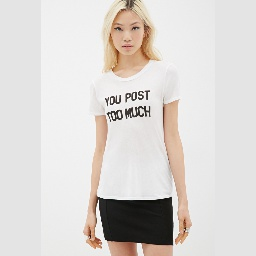

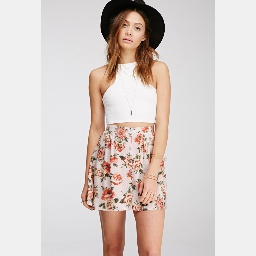

In [ ]:
image = Image.open(IMAGE_PATH / df_test.iloc[5]['image_name'])
display(image)
image = Image.open(IMAGE_PATH / df_test.iloc[15]['image_name'])
display(image)

In [ ]:
def describe_request(image):
    inputs = processor(image,  return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print('caption:', generated_text)

def vqa_request(image,prompt):
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=30)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print('prompt: ',prompt)
    print(generated_text)

def teste_imagens():
  image_paths = ['img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png', 'img6.png']
  images = [Image.open(image_path) for image_path in image_paths]

  # image 1
  image = images[0]
  h,w = image.size
  display(image.resize((h//2,w//2)))
  print('image 1 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the jeans? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the jeans details? Answer:"
  vqa_request(image,prompt)



  # image 2
  image = images[1]
  h,w = image.size
  display(image.resize((h//2,w//2)))
  print('image 2 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the short details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the pants details? Answer:"
  vqa_request(image,prompt)


  # image 3
  image = images[2]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 3 | describe:')
  describe_request(image)
  prompt = "Question: What is the dinosaur holding? Answer:"
  vqa_request(image,prompt)
  prompt = "this is a cartoon of"
  vqa_request(image,prompt)
  prompt = "they look like they are"
  vqa_request(image,prompt)

  # image 4
  image = images[3]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 4 | describe:')
  describe_request(image)
  prompt = "Question: Why are they standing around? Answer:"
  vqa_request(image,prompt)

  # image 5
  image = images[4]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 5 | describe:')
  describe_request(image)
  prompt = "Question: What color is the book on the far right? Answer:"
  vqa_request(image,prompt)

  # image 6
  image = images[5]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 6 | describe:')
  describe_request(image)
  prompt = "Question: Is this a modern train? Answer:"
  vqa_request(image,prompt)

  #test_image 5
  image = Image.open(IMAGE_PATH / df_test.iloc[5]['image_name'])
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('test image 5 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the pants details? Answer:"
  vqa_request(image,prompt)


  #test_image 35
  image = Image.open(IMAGE_PATH / df_test.iloc[15]['image_name'])
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 6 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the pants details? Answer:"
  vqa_request(image,prompt)


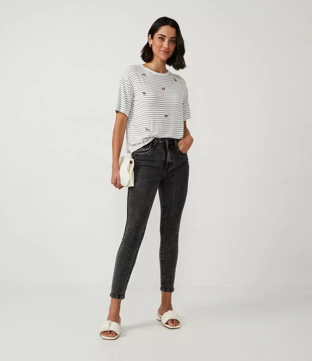

image 1 | describe:
caption: the model wears the jeans and a white t - shirt
prompt:  Question: What is she wearing? Answer:
A white t - shirt and grey skinny jeans
prompt:  Question: What is the color of the shirt? Answer:
Grey
prompt:  Question: What is the shirt color? Answer:
Grey
prompt:  Question: What is the color of the jeans? Answer:
Grey
prompt:  Question: What is the color of the pants? Answer:
Grey
prompt:  Question: Describe the shirt details? Answer:
The shirt has a white and grey striped design
prompt:  Question: What are the shirt details? Answer:
The shirt details are the buttons and the
prompt:  Question: What are the jeans details? Answer:
The jeans are made of a stretchy denim


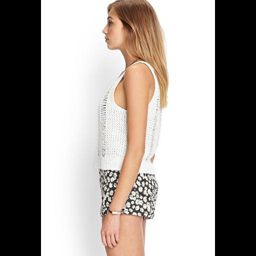

image 2 | describe:
caption: the back of a woman wearing a white tank top and shorts
prompt:  Question: What is she wearing? Answer:
A white crochet tank top and black shorts
prompt:  Question: What is the color of the shirt? Answer:
White
prompt:  Question: What is the shirt color? Answer:
White
prompt:  Question: What is the color of the pants? Answer:
White
prompt:  Question: What are the shirt details? Answer:
The shirt details are the sleeves, the neckline, the collar, the hemline, the back, the sleeves, the neckline, the collar
prompt:  Question: What are the short details? Answer:
The short details are the side cutouts and the side slit
prompt:  Question: What are the pants details? Answer:
The shorts are made of a soft, stretchy fabric that is perfect for summer


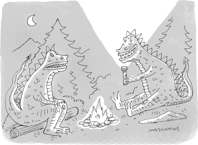

image 3 | describe:
caption: two cartoon monsters sitting around a campfire
prompt:  Question: What is the dinosaur holding? Answer:
A torch
prompt:  this is a cartoon of
two monsters sitting around a campfire
prompt:  they look like they are
having a good time


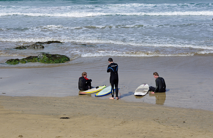

image 4 | describe:
caption: three people sitting on the beach with surfboards
prompt:  Question: Why are they standing around? Answer:
Because they are waiting for the waves to come in


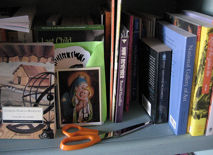

image 5 | describe:
caption: a book shelf with a pair of scissors and a book
prompt:  Question: What color is the book on the far right? Answer:
Orange


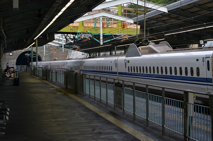

image 6 | describe:
caption: a train is pulling into a station with people on the platform
prompt:  Question: Is this a modern train? Answer:
Yes


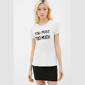

test image 5 | describe:
caption: a woman wearing a white t - shirt that says you post too much
prompt:  Question: What is she wearing? Answer:
She's wearing a white t - shirt with the words you post too much
prompt:  Question: What is the color of the shirt? Answer:
White
prompt:  Question: What is the color of the pants? Answer:
White
prompt:  Question: Describe the shirt? Answer:
It's a white t - shirt with black lettering that says you post too much
prompt:  Question: What are the shirt details? Answer:
The shirt is made of 100% cotton and has a short sleeve, a round neck, a short hem, a short sleeve, a short hem,
prompt:  Question: What are the pants details? Answer:
The pants are made of 100% cotton and have a drawstring waistband


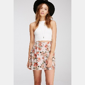

image 6 | describe:
caption: the floral skirt is made from a white crop top and floral print shorts
prompt:  Question: What is she wearing? Answer:
A floral skirt
prompt:  Question: What is the color of the shirt? Answer:
It's a light pink
prompt:  Question: What is the shirt color? Answer:
White
prompt:  Question: What is the color of the pants? Answer:
Pink
prompt:  Question: Describe the shirt? Answer:
floral print crop top
prompt:  Question: What are the shirt details? Answer:
The shirt is a cropped top with a
prompt:  Question: What are the pants details? Answer:
The pants are made of a cotton blend and have a


In [ ]:
teste_imagens()

In [ ]:
notebook_login()

Epoch: 0
Average Epoch Loss: 6.609375  || indx 0
Average Epoch Loss: 0.5230476546906188  || indx 500
Average Epoch Loss: 0.40534453339629123  || indx 1000
Average Epoch Loss: 0.3621356107646985  || indx 1500
epoch loss:
0.3471105276060498


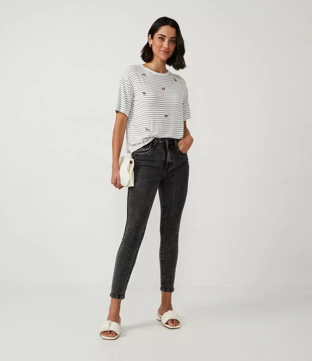

image 1 | describe:
caption: Question: What cloth is the person wearing? Answer: denim
prompt:  Question: What is she wearing? Answer:
tee tank
prompt:  Question: What is the color of the shirt? Answer:
Grey-white-black
prompt:  Question: What is the shirt color? Answer:
Grey-black
prompt:  Question: What is the color of the jeans? Answer:
Grey-white
prompt:  Question: What is the color of the pants? Answer:
Black-white
prompt:  Question: Describe the shirt details? Answer:
yes
prompt:  Question: What are the shirt details? Answer:
denim
prompt:  Question: What are the jeans details? Answer:
denim


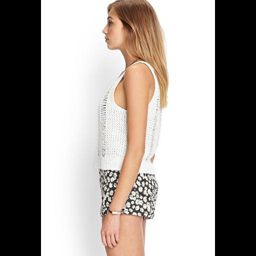

image 2 | describe:
caption: Question: What is the color of the short short? Answer: Cream-black-black-black-black
prompt:  Question: What is she wearing? Answer:
short
prompt:  Question: What is the color of the shirt? Answer:
Cream- black-black-black
prompt:  Question: What is the shirt color? Answer:
Cream-black
prompt:  Question: What is the color of the pants? Answer:
Cream-black-black-black-cream-cream-cream-cream
prompt:  Question: What are the shirt details? Answer:
yes
prompt:  Question: What are the short details? Answer:
short
prompt:  Question: What are the pants details? Answer:
short


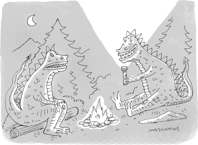

image 3 | describe:
caption: Question: What is this a cartoon? Answer: yes-night-yes-yes-yes-yes-yes-yes-yes-yes-yes-yes-yes--yes-yes-yes-7-7-7
prompt:  Question: What is the dinosaur holding? Answer:
yes-yes-yes-30-30-yes-30-yes-yes-yes--yes-yes-yes-yes
prompt:  this is a cartoon of
the cartoon of a cartoonish?
prompt:  they look like they are
having a fire. a fire.?


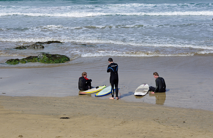

image 4 | describe:
caption: 
prompt:  Question: Why are they standing around? Answer:
yes-p--p--knee----p----p--k-p--p’


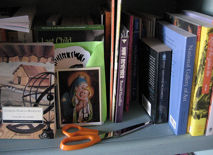

image 5 | describe:
caption: 
prompt:  Question: What color is the book on the far right? Answer:
No-green-orange-orange, but a-green- red-green-orange-green-green---orange-green-green


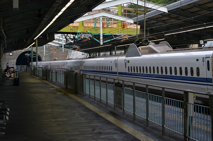

image 6 | describe:
caption: Is this a train?? Answer: yes,- yes,,-yes,-’s-’-yes-yes, this train-’-’s- –-’-’-”-
prompt:  Question: Is this a modern train? Answer:
yes-blue,-white,-blue-blue-white,-blue--blue-red-red-red--red-white


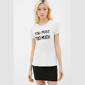

test image 5 | describe:
caption: Question: What is the color of the tee tank? Answer: White-black-black-black-black-black black
prompt:  Question: What is she wearing? Answer:
yes
prompt:  Question: What is the color of the shirt? Answer:
White-black-black black-black-black
prompt:  Question: What is the color of the pants? Answer:
White-black black-black
prompt:  Question: Describe the shirt? Answer:
yes
prompt:  Question: What are the shirt details? Answer:
yes
prompt:  Question: What are the pants details? Answer:
yes


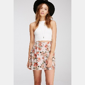

image 6 | describe:
caption: Question: What cloth is the person wearing? Answer: skirt
prompt:  Question: What is she wearing? Answer:
skirt
prompt:  Question: What is the color of the shirt? Answer:
Pink-Pink? Answer: Pink-rose
prompt:  Question: What is the shirt color? Answer:
Pink-cream
prompt:  Question: What is the color of the pants? Answer:
Pink-p-pink-pink? Answer: Cream
prompt:  Question: Describe the shirt? Answer:
yes
prompt:  Question: What are the shirt details? Answer:
short-p-p
prompt:  Question: What are the pants details? Answer:
yes


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Epoch: 1
Average Epoch Loss: 0.451171875  || indx 0


KeyboardInterrupt: 

In [ ]:
import time

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
#a=time.time()
model.train()
for epoch in range(3):
  print("Epoch:", epoch)
  aver_epoch_loss=[]
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    #attention_mask = batch.pop("attention_mask").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    aver_epoch_loss.append(loss.item())
    if idx % 500 ==0:
      print("Average Epoch Loss:", sum(aver_epoch_loss)/len(aver_epoch_loss),' || indx',idx)
      #b=time.time()
      #print('time ',b-a)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  print('epoch loss:')
  print(sum(aver_epoch_loss)/len(aver_epoch_loss))
  teste_imagens()
  model.push_to_hub("leoreigoto/Data3_V3_BLIP2_VQA")